# Neuroverse3D Demonstrations

The following demonstrations showcase Neuroverse3D's capabilities across various tasks, and illustrate how to adjust different context processing settings.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time

from neuroverse3D.lightning_model import LightningModel
from utils.dataloading import *
from utils.task_synthesis import *

## Setting

In [2]:
device = "cuda:0"
checkpoint_path = './checkpoint/neuroverse3D.ckpt'

## Load the Checkpoint

In [3]:
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
hparams = checkpoint['hyper_parameters']

In [4]:
# load model
import warnings
warnings.filterwarnings('ignore')
model = LightningModel.load_from_checkpoint(checkpoint_path, map_location=torch.device(device))
print('Load checkpoint from:', checkpoint_path)
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Load checkpoint from: ./checkpoint/neuroverse3D.ckpt
Total number of parameters:  70854913


# Different tasks

## Segmentation

The following code performs segmentation for three anatomical structures: Cerebral White Matter, Cerebral Cortex, and Thalamus. Foreground indices are [1,20], [2,21], and [7,26], respectively. Refer to ./Demo_data/seg/dataset.json for detailed index information. The provided labels include 35 classes. Feel free to try different classes for segmentation.

In [5]:
# Load data
image_dir = './Demo_data/seg/imgs/'
label_dir = './Demo_data/seg/labs/'
images, labels = load_seg_data(image_dir, label_dir) # load data
size_check(images), size_check(labels) # check size

print('Shape of images:',images.shape, '\nShape of labels:',labels.shape)

Shape of images: (3, 1, 128, 128, 128) 
Shape of labels: (3, 1, 128, 128, 128)


In [6]:
# Build inputs for model 
target_in, context_in, target_out_raw, context_out_raw = structure_data(images, labels, index = 0, verbose = True)

Shape of target_in: (1, 1, 128, 128, 128) 
Shape of target_out: (1, 1, 128, 128, 128)
Shape of context_in: (1, 2, 1, 128, 128, 128) 
Shape of context_out: (1, 2, 1, 128, 128, 128)
The context size is: 2


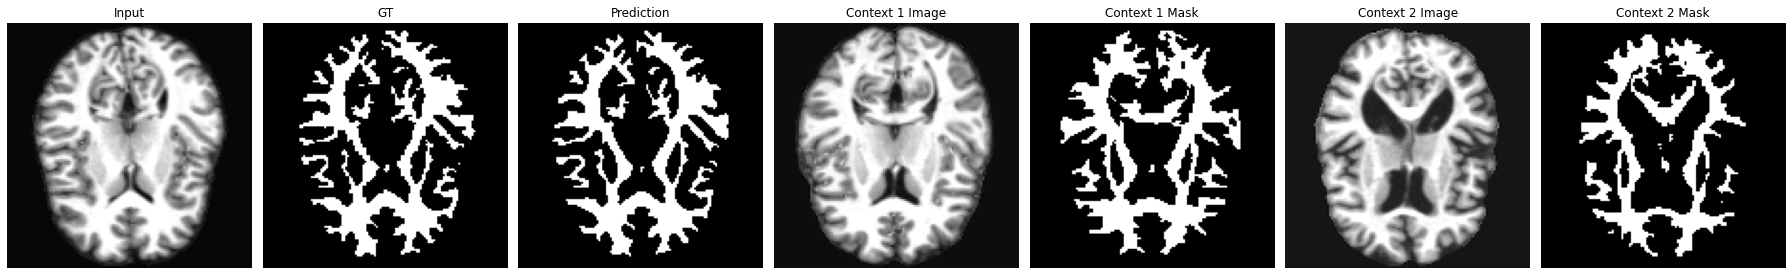

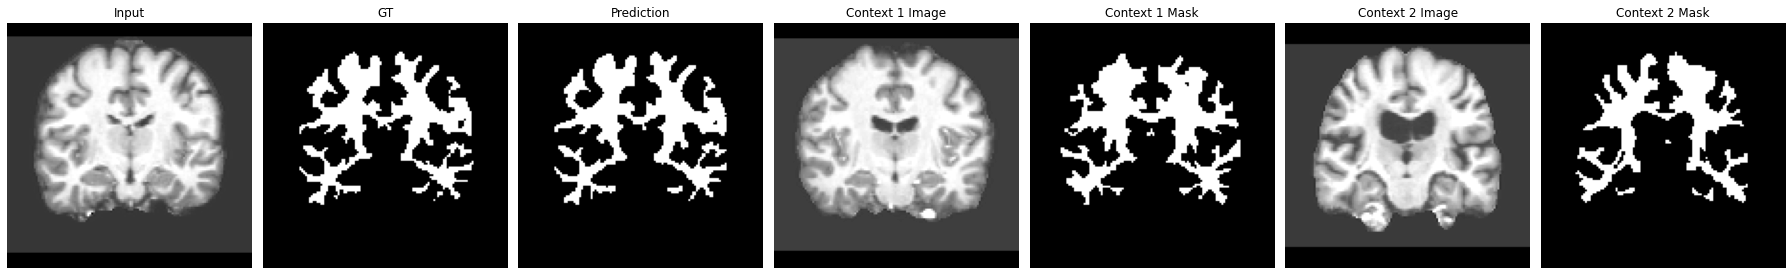

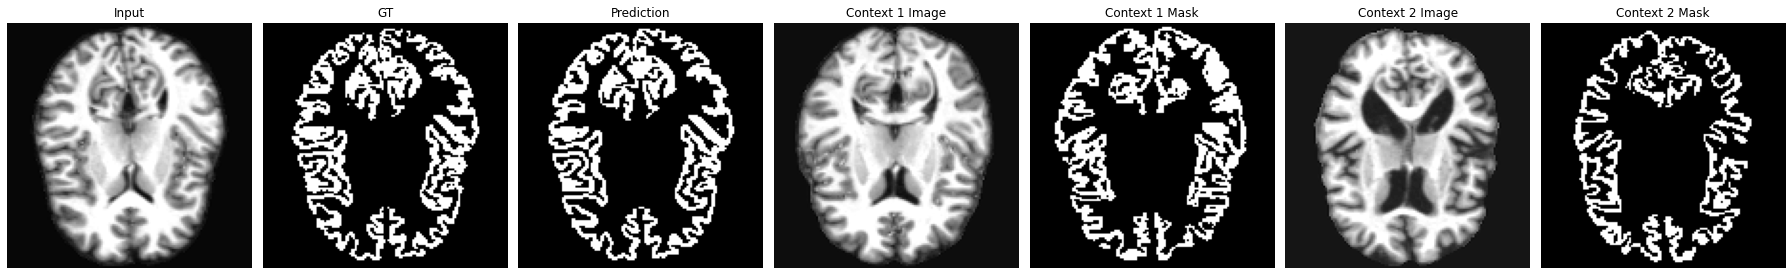

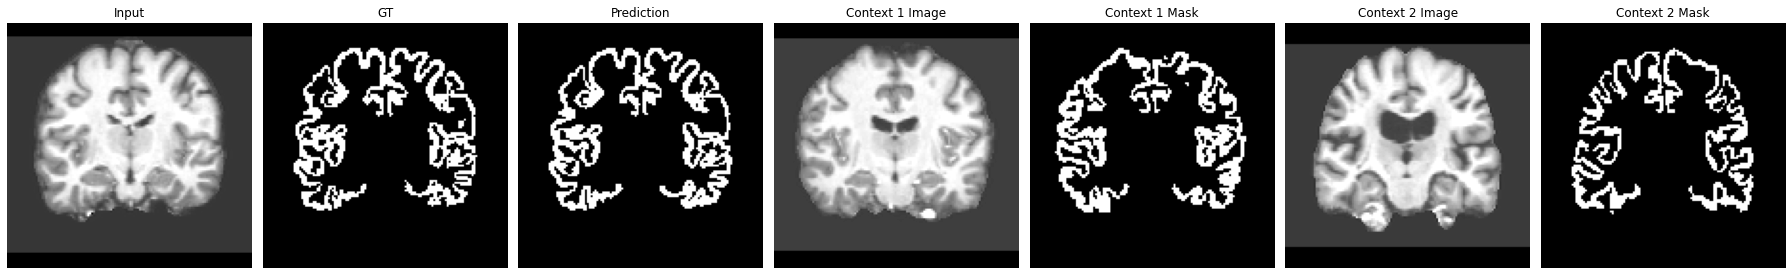

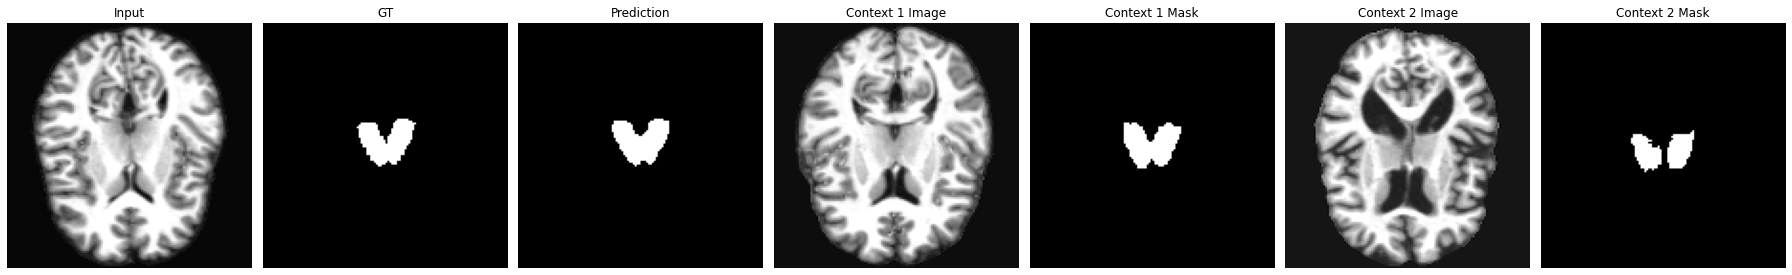

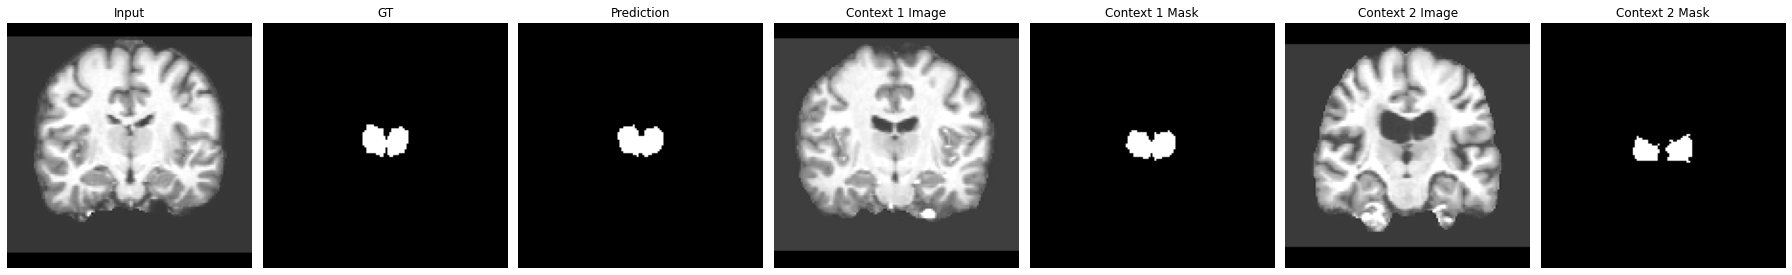

In [7]:
# Evaluation 
for seg_class in [[1,20],[2,21],[7,26]]: # Select foreground class. 
    # Set the foreground class to 1
    context_out = np.isin(context_out_raw, seg_class).astype(np.float32)
    target_out = np.isin(target_out_raw, seg_class).astype(np.float32)

    # Normalization
    target_out = normalize_3d_volume(torch.tensor(target_out).to(device))
    target_in = normalize_3d_volume(torch.tensor(target_in).to(device))
    context_in = normalize_3d_volume(torch.tensor(context_in)) # It is important to keep context in cpu to save memory, when the context size is large.
    context_out = normalize_3d_volume(torch.tensor(context_out))
    
    
    # Run model
    with torch.no_grad():
        mask = model.forward(target_in, context_in, context_out, gs = 2) # gs control the size of mini-context
        
    plot_pred(target_in, target_out, context_in, context_out, mask, slice_=64)
    plot_pred2(target_in, target_out, context_in, context_out, mask, slice_=64)

### Random Brain Region Segmentation
Our model segments arbitrary brain regions based on contextual instructions. To illustrate this, the following code randomly combine three segmentation targets, prompting the model to perform diverse segmentation tasks. Running the code block multiple times will demonstrate the model's performance across various regions.

Selected classes: [ 5. 20. 14.]


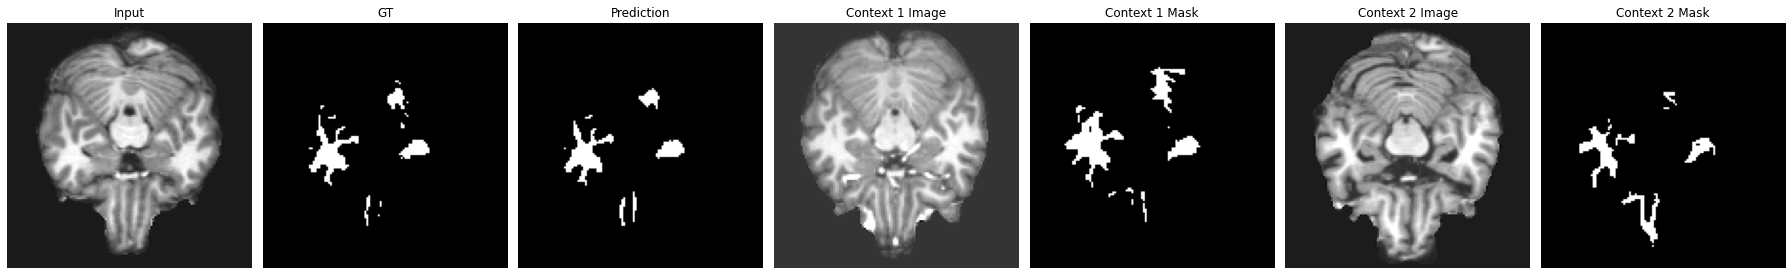

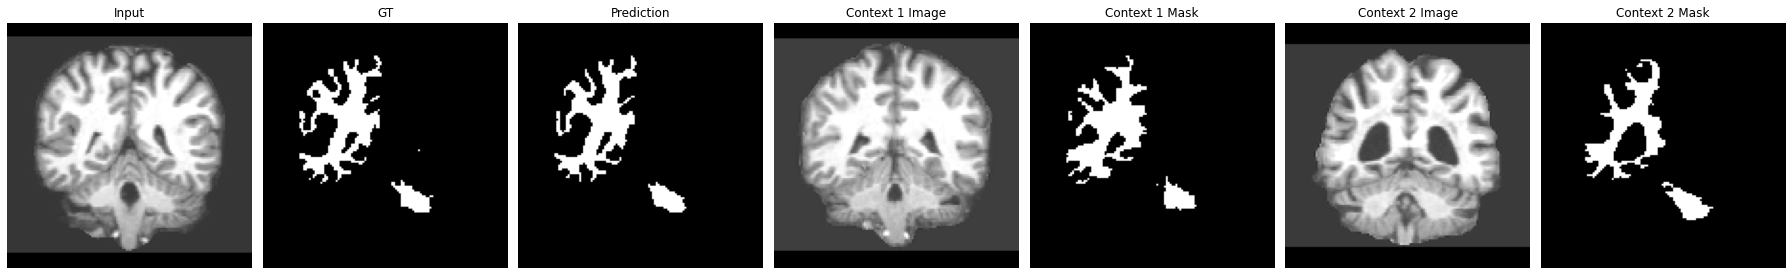

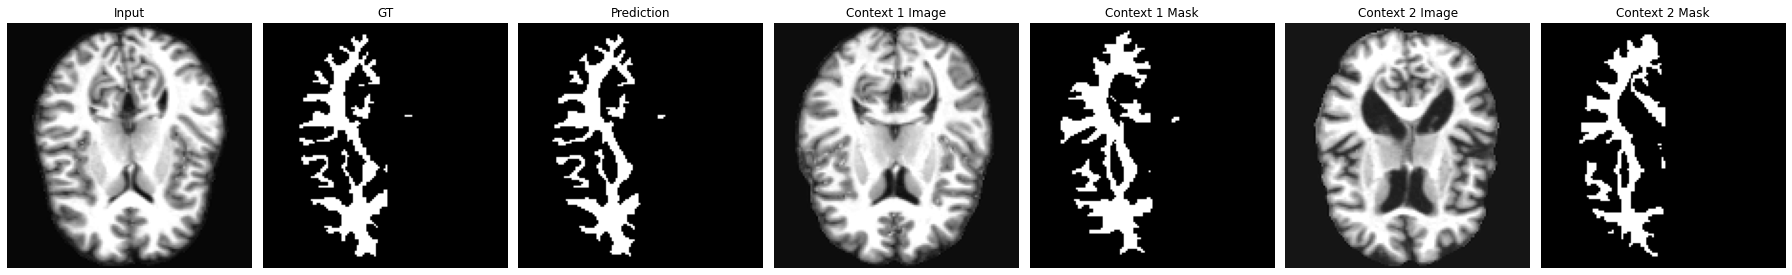

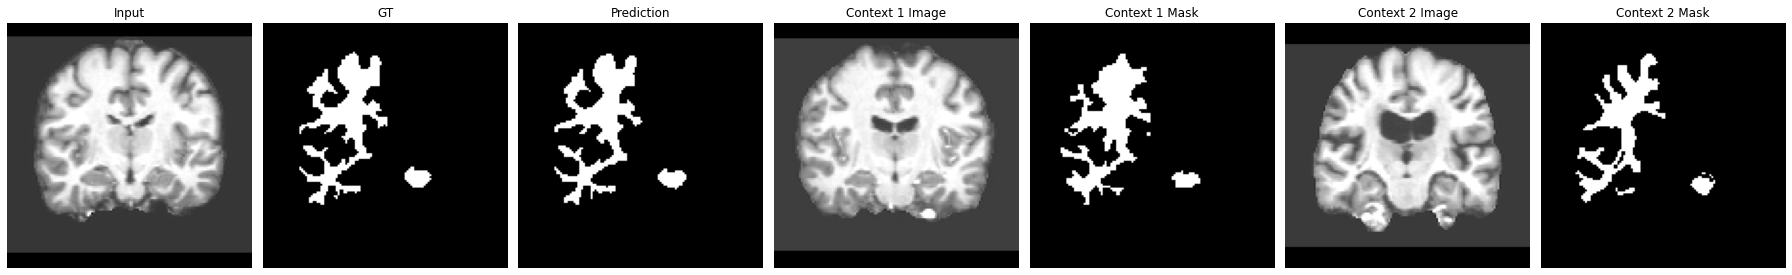

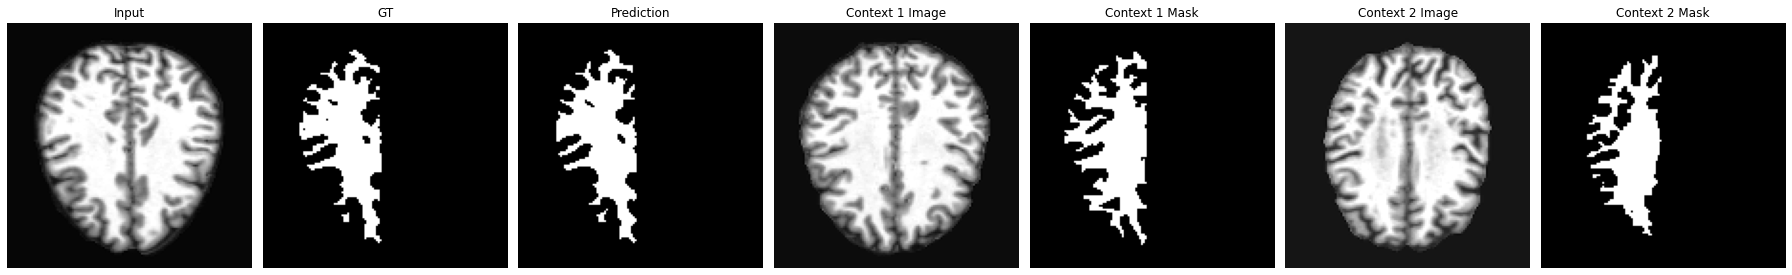

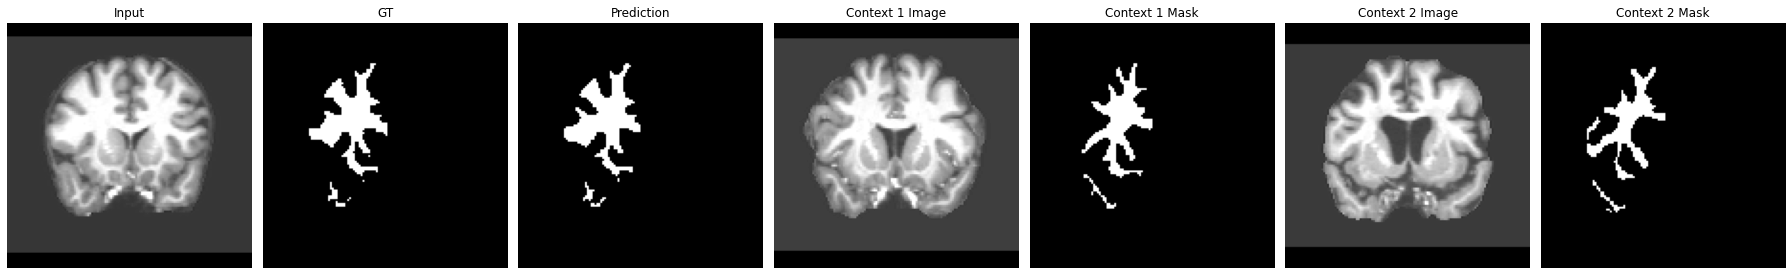

In [61]:
# Set random foreground
unique_masks = np.unique(target_out_raw) 

# Feel free to try different segmentation tasks. 
seg_class = np.random.choice(unique_masks, size=3, replace=False) # randomly select 3 classes
print('Selected classes:',seg_class)

# Set the foreground class to 1
context_out = np.isin(context_out_raw, seg_class).astype(np.float32)
target_out = np.isin(target_out_raw, seg_class).astype(np.float32)

# Normalization
target_out = normalize_3d_volume(torch.tensor(target_out).to(device))
target_in = normalize_3d_volume(torch.tensor(target_in).to(device))
context_in = normalize_3d_volume(torch.tensor(context_in))
context_out = normalize_3d_volume(torch.tensor(context_out))

# Run model
with torch.no_grad():
    mask = model.forward(target_in, context_in, context_out, gs = 2) # gs control the size of mini-context

for slice_ in [44,64,84]:
    plot_pred(target_in, target_out, context_in, context_out, mask, slice_=slice_)
    plot_pred2(target_in, target_out, context_in, context_out, mask, slice_=slice_)

## Generation tasks

In [25]:
# Load data
image_dir = './Demo_data/seg/imgs/'
images= load_gen_data(image_dir, modality = '0000') # load data
labels = images.copy()
size_check(images), size_check(labels) # check size

print('Shape of images:',images.shape, '\nShape of labels:',labels.shape)

Shape of images: (3, 1, 128, 128, 128) 
Shape of labels: (3, 1, 128, 128, 128)


### Gaussian Noise Removal

In [26]:
# Add noise
images_ = process_image(images, add_noise, **{'noise_type' :"gaussian"})
# Build inputs for model 
target_in, context_in, target_out, context_out = structure_data(images_, labels, index = 0, verbose = True)

Shape of target_in: (1, 1, 128, 128, 128) 
Shape of target_out: (1, 1, 128, 128, 128)
Shape of context_in: (1, 2, 1, 128, 128, 128) 
Shape of context_out: (1, 2, 1, 128, 128, 128)
The context size is: 2


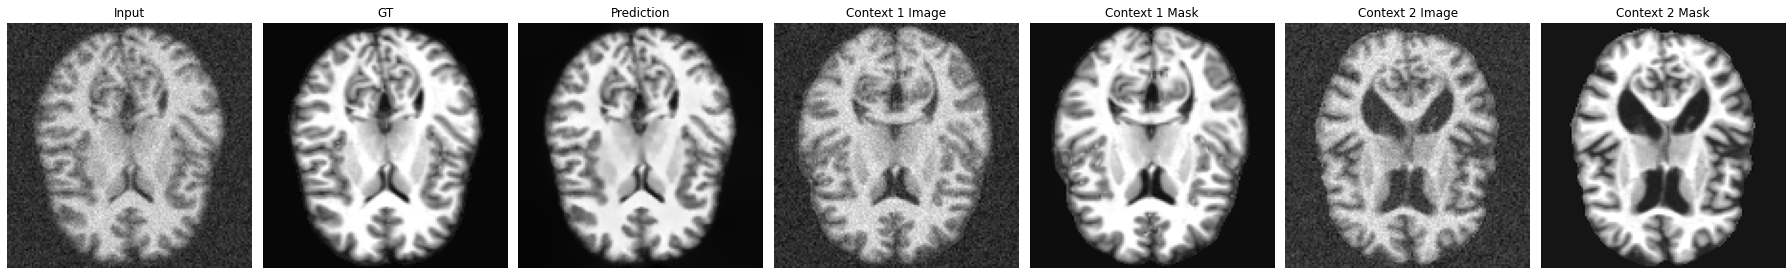

In [27]:
# Normalization
target_out = normalize_3d_volume(torch.tensor(target_out).to(device))
target_in = normalize_3d_volume(torch.tensor(target_in).to(device))
context_in = normalize_3d_volume(torch.tensor(context_in))
context_out = normalize_3d_volume(torch.tensor(context_out))

# Run model
with torch.no_grad():
    mask = model.forward(target_in, context_in, context_out, gs = 2) # gs control the size of mini-context

plot_pred(target_in, target_out, context_in, context_out, mask, slice_=64, task ='gen')

### Salt & Pepper Removal

In [28]:
# Add noise
images_ = process_image(images, add_noise, **{'noise_type' :"salt_pepper"})
# Build inputs for model 
target_in, context_in, target_out, context_out = structure_data(images_, labels, index = 0, verbose = True)

Shape of target_in: (1, 1, 128, 128, 128) 
Shape of target_out: (1, 1, 128, 128, 128)
Shape of context_in: (1, 2, 1, 128, 128, 128) 
Shape of context_out: (1, 2, 1, 128, 128, 128)
The context size is: 2


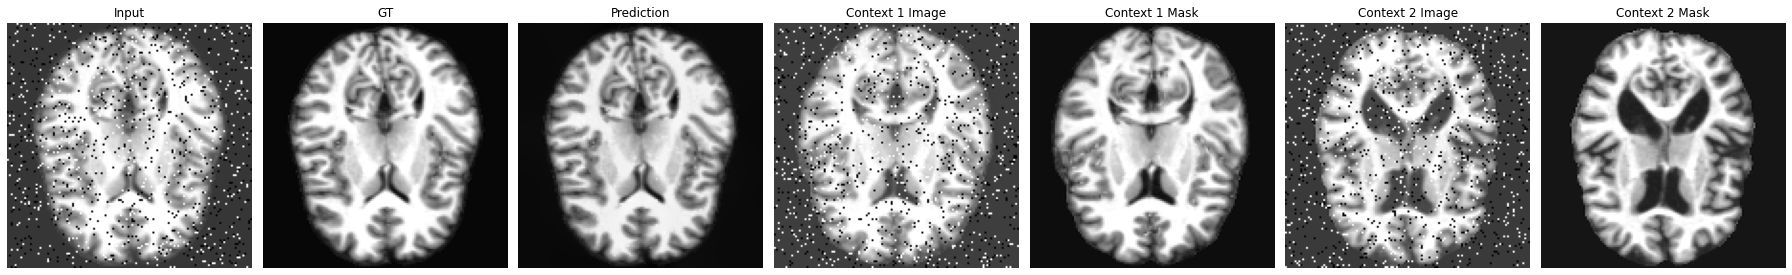

In [29]:
# Normalization
target_out = normalize_3d_volume(torch.tensor(target_out).to(device))
target_in = normalize_3d_volume(torch.tensor(target_in).to(device))
context_in = normalize_3d_volume(torch.tensor(context_in))
context_out = normalize_3d_volume(torch.tensor(context_out))

# Run model
with torch.no_grad():
    mask = model.forward(target_in, context_in, context_out, gs = 2)

plot_pred(target_in, target_out, context_in, context_out, mask, slice_=64, task ='gen')

### Inpainting

In [44]:
# Inpainting
images_ = process_image(images, img_2_painting)
# Build inputs for model 
target_in, context_in, target_out, context_out = structure_data(images_, labels, index = 0, verbose = True)

Shape of target_in: (1, 1, 128, 128, 128) 
Shape of target_out: (1, 1, 128, 128, 128)
Shape of context_in: (1, 2, 1, 128, 128, 128) 
Shape of context_out: (1, 2, 1, 128, 128, 128)
The context size is: 2


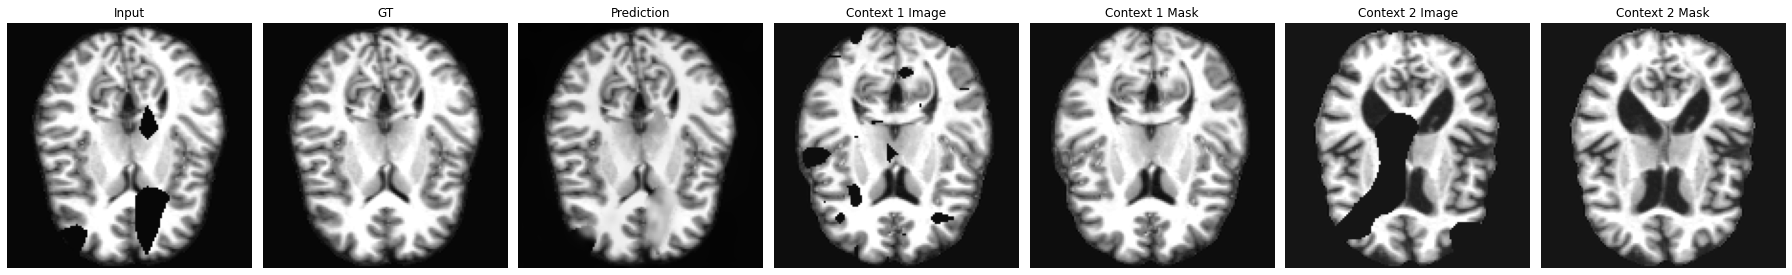

In [45]:
# Normalization
target_out = normalize_3d_volume(torch.tensor(target_out).to(device))
target_in = normalize_3d_volume(torch.tensor(target_in).to(device))
context_in = normalize_3d_volume(torch.tensor(context_in))
context_out = normalize_3d_volume(torch.tensor(context_out))

# Run model
with torch.no_grad():
    mask = model.forward(target_in, context_in, context_out, gs = 2) # gs control the size of mini-context

plot_pred(target_in, target_out, context_in, context_out, mask, slice_=64, task ='gen')

### Modality Transform

In [16]:
# Load data
image_dir = './Demo_data/mod_trans/imgs/'
images= load_gen_data(image_dir, modality = '0000') # load data
label_dir = './Demo_data/mod_trans/imgs/'
labels = load_gen_data(image_dir, modality = '0001') # load data
size_check(images), size_check(labels) # check size

print('Shape of images:',images.shape, '\nShape of labels:',labels.shape)

Shape of images: (3, 1, 128, 128, 128) 
Shape of labels: (3, 1, 128, 128, 128)


In [17]:
# Build inputs for model 
target_in, context_in, target_out, context_out = structure_data(images, labels, index = 0, verbose = True)

Shape of target_in: (1, 1, 128, 128, 128) 
Shape of target_out: (1, 1, 128, 128, 128)
Shape of context_in: (1, 2, 1, 128, 128, 128) 
Shape of context_out: (1, 2, 1, 128, 128, 128)
The context size is: 2


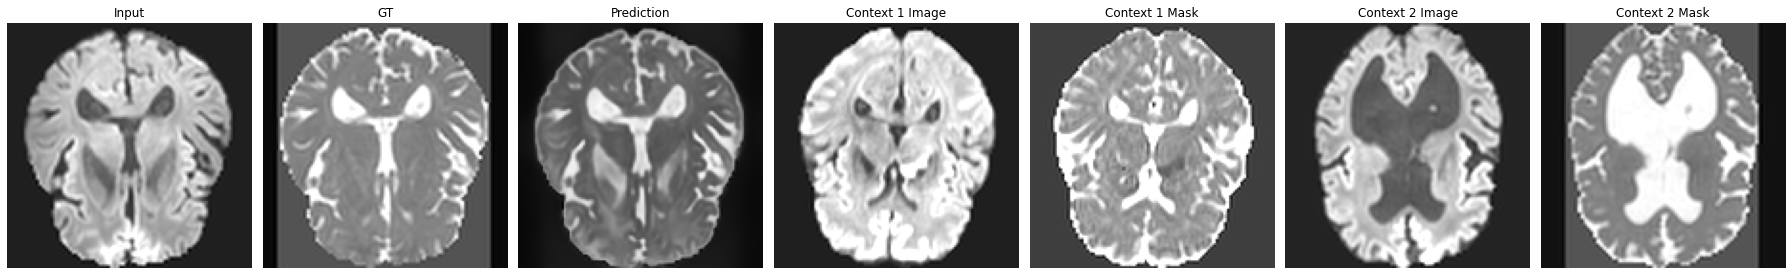

In [18]:
# Normalization
target_out = normalize_3d_volume(torch.tensor(target_out).to(device))
target_in = normalize_3d_volume(torch.tensor(target_in).to(device))
context_in = normalize_3d_volume(torch.tensor(context_in))
context_out = normalize_3d_volume(torch.tensor(context_out))

# Run model
with torch.no_grad():
    mask = model.forward(target_in, context_in, context_out, gs = 2) # gs control the size of mini-context

plot_pred(target_in, target_out, context_in, context_out, mask, slice_=64, task ='gen')

# Support Unlimited Context Size
Our model supports unlimited context size without requiring any additional code modifications. We demonstrate this by expanding the context size to 64 below. Feel free to try larger context size.

In [19]:
context_in = torch.rand(1,64,1,128,128,128)
context_out = torch.rand(1,64,1,128,128,128)
target_in = torch.rand(1,1,128,128,128)

# Normalization
target_out = normalize_3d_volume(torch.tensor(target_out).to(device))
target_in = normalize_3d_volume(torch.tensor(target_in).to(device))
context_in = normalize_3d_volume(torch.tensor(context_in)) # Keep context in cpu to save memory
context_out = normalize_3d_volume(torch.tensor(context_out)) # Keep context in cpu to save memory

# Run model
start_time = time.time()
with torch.no_grad():
    mask2 = model.forward(target_in, context_in, context_out, gs = 2) # mini-context size = 2.
end_time = time.time()

print('Time for context size=64:',end_time-start_time)

Time for context size=64: 7.2543981075286865


In [20]:
context_in = torch.rand(1,2,1,128,128,128)
context_out = torch.rand(1,2,1,128,128,128)
target_in = torch.rand(1,1,128,128,128)

# Normalization
target_out = normalize_3d_volume(torch.tensor(target_out).to(device))
target_in = normalize_3d_volume(torch.tensor(target_in).to(device))
context_in = normalize_3d_volume(torch.tensor(context_in))
context_out = normalize_3d_volume(torch.tensor(context_out))

# Run model
start_time = time.time()
with torch.no_grad():
    mask2 = model.forward(target_in, context_in, context_out, gs = 2) # mini-context size = 2.
end_time = time.time()

print('Time for context size=2:',end_time-start_time)

Time for context size=2: 0.07042694091796875


# Consistency in Terms of Mini-Context Size

We evaluated the impact of varying mini-context sizes, using modality transformation as an example. The intensity difference in predictions across different mini-context sizes was negligible, while smaller mini-context sizes reduced memory requirements.

In [21]:
# Load data
image_dir = './Demo_data/mod_trans/imgs/'
images= load_gen_data(image_dir, modality = '0000') # load data
label_dir = './Demo_data/mod_trans/imgs/'
labels = load_gen_data(image_dir, modality = '0001') # load data
size_check(images), size_check(labels) # check size
print('Shape of images:',images.shape, '\nShape of labels:',labels.shape)

# Build inputs for model 
target_in, context_in, target_out, context_out = structure_data(images, labels, index = 0, verbose = True)

Shape of images: (3, 1, 128, 128, 128) 
Shape of labels: (3, 1, 128, 128, 128)
Shape of target_in: (1, 1, 128, 128, 128) 
Shape of target_out: (1, 1, 128, 128, 128)
Shape of context_in: (1, 2, 1, 128, 128, 128) 
Shape of context_out: (1, 2, 1, 128, 128, 128)
The context size is: 2


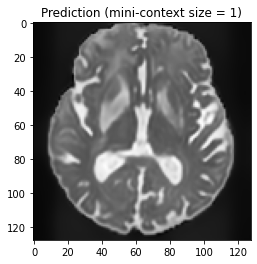

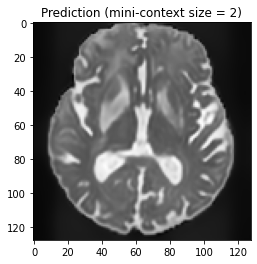

The average divergence across different mini-context sizes is: 3.277307314419886e-10


In [22]:
# Normalization
target_out = normalize_3d_volume(torch.tensor(target_out).to(device))
target_in = normalize_3d_volume(torch.tensor(target_in).to(device))
context_in = normalize_3d_volume(torch.tensor(context_in))
context_out = normalize_3d_volume(torch.tensor(context_out))

# Run model
with torch.no_grad():
    mask1 = model.forward(target_in, context_in, context_out, gs = 1) # mini-context size = 1. 
    mask2 = model.forward(target_in, context_in, context_out, gs = 2) # mini-context size = 2. 

plt.imshow(torch.flip(mask1[0,0,:,:,64].T.cpu(), dims=[-2]),cmap = 'gray'),plt.title('Prediction (mini-context size = 1)'),plt.show()
plt.imshow(torch.flip(mask2[0,0,:,:,64].T.cpu(), dims=[-2]),cmap = 'gray'),plt.title('Prediction (mini-context size = 2)'),plt.show()
print('The average divergence across different mini-context sizes is:',(mask1-mask2).mean().item())